In [432]:
import geopandas as gpd
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, LineString, mapping
from shapely.ops import linemerge, unary_union, LineString, nearest_points
import folium
import math


# Specify the path to the SHP file
shp_file_path = 'stelprdb5332131/PacificCrestTrail.shp'
# Get elevation?
get_elevation = True

## Sorting process
1. Sort by latitude
2. Sort by mile marker
3. Reverse lines

In [433]:
# Read the SHP file into a GeoDataFrame
orig_gdf = gpd.read_file(shp_file_path)

# Filter to only state of WAshington
orig_gdf = orig_gdf[orig_gdf['STATE'] == 'WA']

# Project to WGS1984
orig_gdf = orig_gdf.to_crs(epsg=4326)

In [434]:
# Read mile marker shapefile
shp_file_path = 'Full_PCT_Mile_Marker.shp_/Full_PCT_Mile_Marker.shp'
mile_gdf = gpd.read_file(shp_file_path)

In [435]:
# Initialize a list to store the closest mile for each line
closest_miles = []

# Iterate over each row in orig_gdf
for idx, row in orig_gdf.iterrows():
    # Get the centroid of the line
    line_centroid = row['geometry'].centroid
    
    # Initialize variables to store the closest point and its corresponding mile
    closest_point = None
    closest_mile = None
    min_distance = float('inf')
    
    # Iterate over each row in mile_gdf to find the closest point
    for mile_idx, mile_row in mile_gdf.iterrows():
        # Get the point geometry
        mile_point = mile_row['geometry']
        
        # Calculate the distance between the line centroid and the mile point
        distance = line_centroid.distance(mile_point)
        
        # Update the closest point and mile if this point is closer
        if distance < min_distance:
            min_distance = distance
            closest_point = mile_point
            closest_mile = mile_row['Mile']
    
    # Append the closest mile to the list
    closest_miles.append(closest_mile)

# Add the closest_miles list as a new column in orig_gdf
orig_gdf['Closest_Mile'] = closest_miles


In [ ]:
# Calculate the centroid of each LineString geometry
orig_gdf['centroid'] = orig_gdf['geometry'].centroid

# Extract latitude values of centroids
orig_gdf['centroid_lat'] = orig_gdf['centroid'].y

/tmp/ipykernel_3571/1893242589.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  orig_gdf['centroid'] = orig_gdf['geometry'].centroid


In [ ]:
# Sort orig_gdf by 'Closest_Mile' column in descending order
new_gdf = orig_gdf.sort_values(by='centroid_lat', ascending=False)
# new_gdf = orig_gdf.sort_values(by='Closest_Mile', ascending=False)

# Reset the indices
new_gdf.reset_index(drop=True, inplace=True)

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point

def reorder_lines(gdf):
    # Initialize list to store reordered LineStrings
    reordered_lines = []
    
    # Initialize variable to store the last point of the previous line
    prev_last_point = None
    
    # Iterate over each line in the GeoDataFrame
    for idx, row in gdf.iterrows():
        line = row['geometry']
        
        # Get the first and last points of the line
        first_point = Point(line.coords[0])
        last_point = Point(line.coords[-1])
        
        # Check if previous last point exists and if it is close to the current first point
        if prev_last_point is not None and first_point.distance(prev_last_point) > 50:
            # Reverse the order of points
            line = LineString(list(reversed(line.coords)))
        
        # Update the previous last point
        prev_last_point = last_point
        
        # Append the line to the reordered list
        reordered_lines.append(line)
        
    return reordered_lines

# Apply the function to reorder the lines in new_gdf
reordered_geometries = reorder_lines(new_gdf)

# Create a new GeoDataFrame with the reordered geometries
reordered_gdf = gpd.GeoDataFrame(new_gdf.drop(columns='geometry'), geometry=reordered_geometries, crs=new_gdf.crs)

reordered_gdf.tail()


OWNERTYPE                     OWNERNAME     DESIGNATIO  \
253                       State  WA Dept of Natural Resources   State Forest   
254                       State  WA Dept of Natural Resources   State Forest   
255                     Private               Wauna Lake Club           None   
256                     Private                Wesley Ziegler           None   
257  US Army Corps of Engineers       USACE Portland District  Water project   

                   DESIGNAT_1 MANAGEMENT  \
253  Yacolt Burn State Forest     CRGNSA   
254  Yacolt Burn State Forest     CRGNSA   
255                      None     CRGNSA   
256                      None     CRGNSA   
257   Bonneville Lock and Dam     CRGNSA   

                                    MANAGEME_1  \
253  Columbia River Gorge National Scenic Area   
254  Columbia River Gorge National Scenic Area   
255  Columbia River Gorge National Scenic Area   
256  Columbia River Gorge National Scenic Area   
257  Columbia River Gorge National Scenic Area   

                                      MANAGEME_2 STATE    REV_DATE DATA_SOURC  \
253  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
254  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
255  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
256  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
257  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   

     Closest_Mile                     centroid  centroid_lat  \
253        2151.5  POINT (-121.91918 45.65419)     45.654192   
254        2151.5  POINT (-121.91668 45.65416)     45.654158   
255        2151.5  POINT (-121.91864 45.65412)     45.654121   
256        2152.0  POINT (-121.92767 45.65378)     45.653784   
257        2152.0  POINT (-121.92324 45.65372)     45.653719   

                                              geometry  
253  LINESTRING (-121.91956 45.65421, -121.91905 45...  
254  LINESTRING (-121.91848 45.65408, -121.91836 45...  
255  LINESTRING (-121.91881 45.65411, -121.91870 45...  
256  LINESTRING (-121.92867 45.65431, -121.92855 45...  
257  LINESTRING (-121.92670 45.65344, -121.92669 45...

In [ ]:
import pandas as pd

# Initialize a list to store the data for each point
point_data = []

# Iterate over each row in the GeoDataFrame
for idx, row in reordered_gdf.iterrows():
    # Extract points from the LineString geometry
    points = list(row['geometry'].coords)
    
    # Iterate over each point
    for point in points:
        # Create a dictionary containing the data for the point
        point_info = {
            'OWNERTYPE': row['OWNERTYPE'],
            'OWNERNAME': row['OWNERNAME'],
            'DESIGNATIO': row['DESIGNATIO'],
            'DESIGNAT_1': row['DESIGNAT_1'],
            'MANAGEMENT': row['MANAGEMENT'],
            'MANAGEME_1': row['MANAGEME_1'],
            'MANAGEME_2': row['MANAGEME_2'],
            'STATE': row['STATE'],
            'REV_DATE': row['REV_DATE'],
            'DATA_SOURC': row['DATA_SOURC'],
            'Closest_Mile': row['Closest_Mile'],
            'centroid': row['centroid'],
            'centroid_lat': row['centroid_lat'],
            'geometry': Point(point)  # Convert point coordinates to Point geometry
        }
        
        # Append the point data to the list
        point_data.append(point_info)

# Create a new DataFrame from the list of point data
points_df = pd.DataFrame(point_data)

# Display the new DataFrame
points_df.head()

OWNERTYPE                 OWNERNAME  DESIGNATIO  \
0  USDA Forest Service  Okanogan National Forest  Wilderness   
1  USDA Forest Service  Okanogan National Forest  Wilderness   
2  USDA Forest Service  Okanogan National Forest  Wilderness   
3  USDA Forest Service  Okanogan National Forest  Wilderness   
4  USDA Forest Service  Okanogan National Forest  Wilderness   

            DESIGNAT_1 MANAGEMENT                     MANAGEME_1  \
0  Pasayten Wilderness        OKA  Methow Valley Ranger District   
1  Pasayten Wilderness        OKA  Methow Valley Ranger District   
2  Pasayten Wilderness        OKA  Methow Valley Ranger District   
3  Pasayten Wilderness        OKA  Methow Valley Ranger District   
4  Pasayten Wilderness        OKA  Methow Valley Ranger District   

                                        MANAGEME_2 STATE    REV_DATE  \
0  North Cascades National Park to Canadian Border    WA  2000-09-22   
1  North Cascades National Park to Canadian Border    WA  2000-09-22   
2  North Cascades National Park to Canadian Border    WA  2000-09-22   
3  North Cascades National Park to Canadian Border    WA  2000-09-22   
4  North Cascades National Park to Canadian Border    WA  2000-09-22   

  DATA_SOURC  Closest_Mile                                       centroid  \
0         01        2651.5  POINT (-120.77920199340596 48.95233353032442)   
1         01        2651.5  POINT (-120.77920199340596 48.95233353032442)   
2         01        2651.5  POINT (-120.77920199340596 48.95233353032442)   
3         01        2651.5  POINT (-120.77920199340596 48.95233353032442)   
4         01        2651.5  POINT (-120.77920199340596 48.95233353032442)   

   centroid_lat                                        geometry  
0     48.952334  POINT (-120.79988038416772 48.999852033358955)  
1     48.952334   POINT (-120.79995559329751 48.99938559650756)  
2     48.952334   POINT (-120.7999520589351 48.998845802832896)  
3     48.952334   POINT (-120.80006458012635 48.99815521863299)  
4     48.952334   POINT (-120.80028279530028 48.99754759295567)

In [431]:
from shapely.geometry import LineString

# Extract coordinates of points from the DataFrame
point_coords = [(point.x, point.y) for point in points_df['geometry']]

# Create a LineString from the collected coordinates
single_line = LineString(point_coords)

# Convert the LineString to a list of coordinates for Folium
line_coords = [(coord[1], coord[0]) for coord in single_line.coords]

# Create a Folium map centered around the first point of the line
m = folium.Map(location=line_coords[0], zoom_start=10)

# Add the LineString to the map
folium.PolyLine(locations=line_coords, color='blue').add_to(m)

# Display the map
m


In [376]:
from shapely.geometry import LineString

# Extracting all coordinates from the geometry column
coordinates = [point for line in new_gdf['geometry'] for point in line.coords]

# Creating a LineString from all the collected coordinates
combined_line = LineString(coordinates)

# Calculate the length of the LineString
length = combined_line.length

print("Length of the combined LineString:", length*69, "miles")


Length of the combined LineString: 759.2974702352824 miles


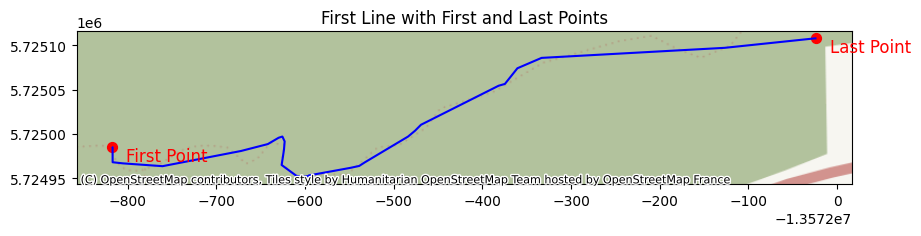

In [309]:
# Project to Web Mercator (EPSG:3857)
new_gdf_wm = new_gdf.to_crs(epsg=3857)

# Plot the first line of new_gdf with its first and last points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first line
first_line = new_gdf_wm['geometry'].iloc[-1]
gpd.GeoSeries(first_line).plot(ax=ax, color='blue')

# Plot the first and last points
first_point = Point(first_line.coords[0])
last_point = Point(first_line.coords[-1])
gpd.GeoSeries([first_point, last_point]).plot(ax=ax, color='red', markersize=50)

# Add labels for the first and last points
ax.annotate('First Point', (first_point.x, first_point.y), xytext=(10, -10), textcoords='offset points', color='red', fontsize=12)
ax.annotate('Last Point', (last_point.x, last_point.y), xytext=(10, -10), textcoords='offset points', color='red', fontsize=12)

# Add basemap
ctx.add_basemap(ax, crs=new_gdf_wm.crs.to_string())

# Show plot
plt.title('First Line with First and Last Points')
plt.show()

In [310]:
# Assuming 'new_gdf' is your GeoDataFrame containing the line geometry

# Project to WGS84 (EPSG:4326)
new_gdf_wm = new_gdf.to_crs(epsg=4326)

# Create a Folium map centered around the first point of the first line
first_line = new_gdf_wm['geometry'].iloc[0]
m = folium.Map(location=[first_line.coords[0][1], first_line.coords[0][0]], zoom_start=10)

# Add all lines to the map
for line in new_gdf_wm['geometry']:
    folium.GeoJson(mapping(line), style_function=lambda x: {'color': 'blue'}).add_to(m)

# Add markers for the first and last points of each line with labels
for line in new_gdf_wm['geometry']:
    first_point = Point(line.coords[0][::-1])  # Folium expects (lat, lon) instead of (lon, lat)
    last_point = Point(line.coords[-1][::-1])

    # Add markers with labels for the first and last points of each line
    folium.Marker(
        location=[first_point.y, first_point.x],
        icon=folium.Icon(color='red'),
        popup=folium.Popup('First Point', parse_html=True)  # Label for the first point
    ).add_to(m)

    folium.Marker(
        location=[last_point.y, last_point.x],
        icon=folium.Icon(color='red'),
        popup=folium.Popup('Last Point', parse_html=True)  # Label for the last point
    ).add_to(m)

# Display the map
m


In [311]:
new_gdf

OWNERTYPE                     OWNERNAME     DESIGNATIO  \
0           USDA Forest Service      Okanogan National Forest     Wilderness   
1           USDA Forest Service      Okanogan National Forest     Wilderness   
2           USDA Forest Service      Okanogan National Forest     Wilderness   
3           USDA Forest Service      Okanogan National Forest     Wilderness   
4           USDA Forest Service      Okanogan National Forest     Wilderness   
..                          ...                           ...            ...   
253                       State  WA Dept of Natural Resources   State Forest   
254                       State  WA Dept of Natural Resources   State Forest   
255                     Private               Wauna Lake Club           None   
256                     Private                Wesley Ziegler           None   
257  US Army Corps of Engineers       USACE Portland District  Water project   

                   DESIGNAT_1 MANAGEMENT  \
0         Pasayten Wilderness        OKA   
1         Pasayten Wilderness        OKA   
2         Pasayten Wilderness        OKA   
3         Pasayten Wilderness        OKA   
4         Pasayten Wilderness        OKA   
..                        ...        ...   
253  Yacolt Burn State Forest     CRGNSA   
254  Yacolt Burn State Forest     CRGNSA   
255                      None     CRGNSA   
256                      None     CRGNSA   
257   Bonneville Lock and Dam     CRGNSA   

                                    MANAGEME_1  \
0                Methow Valley Ranger District   
1                Methow Valley Ranger District   
2                Methow Valley Ranger District   
3                Methow Valley Ranger District   
4                Methow Valley Ranger District   
..                                         ...   
253  Columbia River Gorge National Scenic Area   
254  Columbia River Gorge National Scenic Area   
255  Columbia River Gorge National Scenic Area   
256  Columbia River Gorge National Scenic Area   
257  Columbia River Gorge National Scenic Area   

                                          MANAGEME_2 STATE    REV_DATE  \
0    North Cascades National Park to Canadian Border    WA  2000-09-22   
1    North Cascades National Park to Canadian Border    WA  2000-09-22   
2    North Cascades National Park to Canadian Border    WA  2006-10-04   
3    North Cascades National Park to Canadian Border    WA  2000-09-22   
4    North Cascades National Park to Canadian Border    WA  2000-09-22   
..                                               ...   ...         ...   
253      Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
254      Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
255      Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
256      Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
257      Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   

    DATA_SOURC                                           geometry  
0           01  LINESTRING (-59905.820 1212329.130, -59911.880...  
1           01  LINESTRING (-57857.390 1203102.420, -57867.880...  
2           24  LINESTRING (-56646.860 1198664.020, -56606.030...  
3           01  LINESTRING (-55225.730 1194270.730, -55243.140...  
4           01  LINESTRING (-55225.730 1194270.730, -55209.300...  
..         ...                                                ...  
253         03  LINESTRING (-151104.240 847661.650, -151104.32...  
254         03  LINESTRING (-151078.000 847657.560, -151068.25...  
255         03  LINESTRING (-151078.000 847657.560, -151078.01...  
256         03  LINESTRING (-151726.520 847600.500, -151727.97...  
257         03  LINESTRING (-151726.520 847600.500, -151726.01...  

[258 rows x 11 columns]

# Get elevation if not already saved as new .shp file

In [312]:
# Convert to target CRS (WGS 84) for elevation retrieval
if get_elevation == True:

    def get_topo_data(locations):
        """
        Get topographic data from the Open Topo Data API for given locations.

        Parameters:
        locations (str): Comma-separated coordinates in the format 'latitude,longitude'.

        Returns:
        dict: JSON response containing topographic data.
        """
        # Define the API endpoint URL
        url = "https://api.opentopodata.org/v1/test-dataset"

        # Define the parameters for the request
        params = {
            "locations": locations
        }

        # Make the GET request
        response = requests.get(url, params=params)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Return the JSON response
            return response.json()
        else:
            # Print an error message if the request failed
            print("Error:", response.status_code)
            return None

    # Define the target CRS (WGS 84)
    target_crs = 'EPSG:4326'

    # Project the GeoDataFrame to WGS 84
    gdf_wgs84 = new_gdf.to_crs(target_crs)

    # Display the GeoDataFrame with points projected to WGS 84
    gdf_wgs84.tail()


In [313]:
gdf_wgs84.tail()

OWNERTYPE                     OWNERNAME     DESIGNATIO  \
253                       State  WA Dept of Natural Resources   State Forest   
254                       State  WA Dept of Natural Resources   State Forest   
255                     Private               Wauna Lake Club           None   
256                     Private                Wesley Ziegler           None   
257  US Army Corps of Engineers       USACE Portland District  Water project   

                   DESIGNAT_1 MANAGEMENT  \
253  Yacolt Burn State Forest     CRGNSA   
254  Yacolt Burn State Forest     CRGNSA   
255                      None     CRGNSA   
256                      None     CRGNSA   
257   Bonneville Lock and Dam     CRGNSA   

                                    MANAGEME_1  \
253  Columbia River Gorge National Scenic Area   
254  Columbia River Gorge National Scenic Area   
255  Columbia River Gorge National Scenic Area   
256  Columbia River Gorge National Scenic Area   
257  Columbia River Gorge National Scenic Area   

                                      MANAGEME_2 STATE    REV_DATE DATA_SOURC  \
253  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
254  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
255  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
256  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   
257  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06         03   

                                              geometry  
253  LINESTRING (-121.91881 45.65411, -121.91881 45...  
254  LINESTRING (-121.91848 45.65408, -121.91836 45...  
255  LINESTRING (-121.91848 45.65408, -121.91848 45...  
256  LINESTRING (-121.92670 45.65344, -121.92671 45...  
257  LINESTRING (-121.92670 45.65344, -121.92669 45...

In [314]:
# Extract lon and lat from points to new columns for elevation retrieval
if get_elevation:
    # Create an empty list to store the new rows
    new_rows = []

    # Iterate over rows of the GeoDataFrame
    for index, row in gdf_wgs84.iterrows():
        # Extract line coordinates using list comprehension
        line_coordinates = [(coord[0], coord[1]) for coord in row['geometry'].coords]
        
        # Create a new row for each coordinate pair
        for lon, lat in line_coordinates:
            new_row = {
                'OWNERTYPE': row['OWNERTYPE'],
                'OWNERNAME': row['OWNERNAME'],
                'DESIGNATIO': row['DESIGNATIO'],
                'DESIGNAT_1': row['DESIGNAT_1'],
                'MANAGEMENT': row['MANAGEMENT'],
                'MANAGEME_1': row['MANAGEME_1'],
                'MANAGEME_2': row['MANAGEME_2'],
                'STATE': row['STATE'],
                'REV_DATE': row['REV_DATE'],
                'DATA_SOURC': row['DATA_SOURC'],
                'lon': lon,
                'lat': lat
            }
            # Append the new row to the list
            new_rows.append(new_row)

    # Create a DataFrame from the list of new rows
    gdf_wgs84 = pd.DataFrame(new_rows)


In [315]:
gdf_wgs84.head()

OWNERTYPE                 OWNERNAME  DESIGNATIO  \
0  USDA Forest Service  Okanogan National Forest  Wilderness   
1  USDA Forest Service  Okanogan National Forest  Wilderness   
2  USDA Forest Service  Okanogan National Forest  Wilderness   
3  USDA Forest Service  Okanogan National Forest  Wilderness   
4  USDA Forest Service  Okanogan National Forest  Wilderness   

            DESIGNAT_1 MANAGEMENT                     MANAGEME_1  \
0  Pasayten Wilderness        OKA  Methow Valley Ranger District   
1  Pasayten Wilderness        OKA  Methow Valley Ranger District   
2  Pasayten Wilderness        OKA  Methow Valley Ranger District   
3  Pasayten Wilderness        OKA  Methow Valley Ranger District   
4  Pasayten Wilderness        OKA  Methow Valley Ranger District   

                                        MANAGEME_2 STATE    REV_DATE  \
0  North Cascades National Park to Canadian Border    WA  2000-09-22   
1  North Cascades National Park to Canadian Border    WA  2000-09-22   
2  North Cascades National Park to Canadian Border    WA  2000-09-22   
3  North Cascades National Park to Canadian Border    WA  2000-09-22   
4  North Cascades National Park to Canadian Border    WA  2000-09-22   

  DATA_SOURC         lon        lat  
0         01 -120.799880  48.999852  
1         01 -120.799956  48.999386  
2         01 -120.799952  48.998846  
3         01 -120.800065  48.998155  
4         01 -120.800283  48.997548

In [316]:
if get_elevation:
    gdf_wgs84['elevation'] = pd.Series([pd.np.nan] * len(gdf_wgs84), index=gdf_wgs84.index)

/tmp/ipykernel_3571/2853650783.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  gdf_wgs84['elevation'] = pd.Series([pd.np.nan] * len(gdf_wgs84), index=gdf_wgs84.index)


In [317]:
if get_elevation:

    import time
    # Splitting locations into batches of 100
    batch_size = 100
    num_batches = -(-len(gdf_wgs84) // batch_size)  # Ceiling division to compute the number of batches
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(gdf_wgs84))
        batch_locations = [{"latitude": row['lat'], "longitude": row['lon']} for idx, row in gdf_wgs84.iloc[start_index:end_index].iterrows()]

        # API URL
        url = 'https://api.open-elevation.com/api/v1/lookup'

        # Sending POST request to the API
        response = requests.post(url, json={"locations": batch_locations})

        # Check if request was successful (status code 200)
        if response.status_code == 200:
            # Extract elevation data from the response
            elevation_data = response.json()['results']

            # Add elevation data to the GeoDataFrame
            gdf_wgs84.iloc[start_index:end_index, gdf_wgs84.columns.get_loc('elevation')] = [result['elevation'] for result in elevation_data]

        else:
            print("Error:", response.status_code)

        # Introduce a delay to avoid exceeding rate limit
        time.sleep(1)  # Sleep for 1 second between each batch



Error: 504
Error: 504


In [318]:
gdf_wgs84.head()

OWNERTYPE                 OWNERNAME  DESIGNATIO  \
0  USDA Forest Service  Okanogan National Forest  Wilderness   
1  USDA Forest Service  Okanogan National Forest  Wilderness   
2  USDA Forest Service  Okanogan National Forest  Wilderness   
3  USDA Forest Service  Okanogan National Forest  Wilderness   
4  USDA Forest Service  Okanogan National Forest  Wilderness   

            DESIGNAT_1 MANAGEMENT                     MANAGEME_1  \
0  Pasayten Wilderness        OKA  Methow Valley Ranger District   
1  Pasayten Wilderness        OKA  Methow Valley Ranger District   
2  Pasayten Wilderness        OKA  Methow Valley Ranger District   
3  Pasayten Wilderness        OKA  Methow Valley Ranger District   
4  Pasayten Wilderness        OKA  Methow Valley Ranger District   

                                        MANAGEME_2 STATE    REV_DATE  \
0  North Cascades National Park to Canadian Border    WA  2000-09-22   
1  North Cascades National Park to Canadian Border    WA  2000-09-22   
2  North Cascades National Park to Canadian Border    WA  2000-09-22   
3  North Cascades National Park to Canadian Border    WA  2000-09-22   
4  North Cascades National Park to Canadian Border    WA  2000-09-22   

  DATA_SOURC         lon        lat  elevation  
0         01 -120.799880  48.999852     1411.0  
1         01 -120.799956  48.999386     1411.0  
2         01 -120.799952  48.998846     1411.0  
3         01 -120.800065  48.998155     1342.0  
4         01 -120.800283  48.997548     1362.0

In [319]:
# Convert back to points and remove lon and lat columns
if get_elevation:

    # Create a geometry column from lon and lat
    geometry = [Point(lon, lat)for lon, lat in zip(gdf_wgs84['lon'], gdf_wgs84['lat'])]

    # Create a GeoDataFrame
    gdf_wgs84 = gpd.GeoDataFrame(gdf_wgs84, geometry=geometry, crs='EPSG:4326')

    # Drop lon and lat columns if needed
    gdf_wgs84.drop(columns=['lon', 'lat'], inplace=True)

    # Display the new GeoDataFrame
    gdf_wgs84.head()


In [320]:
# Save to SHP file for later use
if get_elevation:
    # Specify the file path where you want to save the shapefile
    output_shapefile = 'PCT_w_elevation.shp'

    # Save the GeoPandas DataFrame to a shapefile
    gdf_wgs84.to_file(output_shapefile, driver='ESRI Shapefile')

# Load shapefile with pre-found elevation

In [321]:
# Specify the path to the JSON file
pct_elevation_path = 'PCT_w_elevation.shp'

# Read the JSON file into a GeoDataFrame
gdf = gpd.read_file(pct_elevation_path)
gdf.head()

OWNERTYPE                 OWNERNAME  DESIGNATIO  \
0  USDA Forest Service  Okanogan National Forest  Wilderness   
1  USDA Forest Service  Okanogan National Forest  Wilderness   
2  USDA Forest Service  Okanogan National Forest  Wilderness   
3  USDA Forest Service  Okanogan National Forest  Wilderness   
4  USDA Forest Service  Okanogan National Forest  Wilderness   

            DESIGNAT_1 MANAGEMENT                     MANAGEME_1  \
0  Pasayten Wilderness        OKA  Methow Valley Ranger District   
1  Pasayten Wilderness        OKA  Methow Valley Ranger District   
2  Pasayten Wilderness        OKA  Methow Valley Ranger District   
3  Pasayten Wilderness        OKA  Methow Valley Ranger District   
4  Pasayten Wilderness        OKA  Methow Valley Ranger District   

                                        MANAGEME_2 STATE    REV_DATE  \
0  North Cascades National Park to Canadian Border    WA  2000-09-22   
1  North Cascades National Park to Canadian Border    WA  2000-09-22   
2  North Cascades National Park to Canadian Border    WA  2000-09-22   
3  North Cascades National Park to Canadian Border    WA  2000-09-22   
4  North Cascades National Park to Canadian Border    WA  2000-09-22   

  DATA_SOURC  elevation                     geometry  
0         01     1411.0  POINT (-120.79988 48.99985)  
1         01     1411.0  POINT (-120.79996 48.99939)  
2         01     1411.0  POINT (-120.79995 48.99885)  
3         01     1342.0  POINT (-120.80006 48.99816)  
4         01     1362.0  POINT (-120.80028 48.99755)

In [322]:
# Convert all points into a single LineString
single_line = LineString(list(gdf['geometry']))

# Create a GeoDataFrame containing the single LineString
single_line_gdf = gpd.GeoDataFrame(geometry=[single_line], crs='EPSG:4326')

# Display the new GeoDataFrame
print(single_line_gdf.head())
# Project to UTM 10N
target_crs = 'EPSG:6339'
single_line_gdf = single_line_gdf.to_crs(target_crs)
# Calculate the total length of all the lines
total_length = sum(single_line_gdf['geometry'].length)

# Print the total length
print("Total length of all lines:", total_length/1609)

m = folium.Map(location=[single_line.centroid.y, single_line.centroid.x], zoom_start=10)

# Add the LineString to the map
folium.GeoJson(single_line_gdf).add_to(m)

# Display the map
m

                                            geometry
0  LINESTRING (-120.79988 48.99985, -120.79996 48...
Total length of all lines: 519.0383090462661


In [323]:
# Project to UTM 10N
target_crs = 'EPSG:6339'
gdf = gdf.to_crs(target_crs)
gdf.tail()


OWNERTYPE                OWNERNAME     DESIGNATIO  \
40466  US Army Corps of Engineers  USACE Portland District  Water project   
40467  US Army Corps of Engineers  USACE Portland District  Water project   
40468  US Army Corps of Engineers  USACE Portland District  Water project   
40469  US Army Corps of Engineers  USACE Portland District  Water project   
40470  US Army Corps of Engineers  USACE Portland District  Water project   

                    DESIGNAT_1 MANAGEMENT  \
40466  Bonneville Lock and Dam     CRGNSA   
40467  Bonneville Lock and Dam     CRGNSA   
40468  Bonneville Lock and Dam     CRGNSA   
40469  Bonneville Lock and Dam     CRGNSA   
40470  Bonneville Lock and Dam     CRGNSA   

                                      MANAGEME_1  \
40466  Columbia River Gorge National Scenic Area   
40467  Columbia River Gorge National Scenic Area   
40468  Columbia River Gorge National Scenic Area   
40469  Columbia River Gorge National Scenic Area   
40470  Columbia River Gorge National Scenic Area   

                                        MANAGEME_2 STATE    REV_DATE  \
40466  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
40467  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
40468  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
40469  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   
40470  Mark Hatfield Wilderness Bdy to DNR Rd 2000    WA  2006-02-06   

      DATA_SOURC  elevation                        geometry  
40466         03       29.0  POINT (583944.796 5056169.616)  
40467         03       29.0  POINT (583963.750 5056178.035)  
40468         03       33.0  POINT (584108.135 5056187.890)  
40469         03       86.0  POINT (584178.896 5056196.250)  
40470         03       86.0  POINT (584180.537 5056196.337)

In [324]:
def calculate_3d_distance(df):
    # Calculate 3D distance between consecutive points
    distances = []
    for i in range(1, len(df)):
        point1 = df.iloc[i - 1]['geometry']
        point2 = df.iloc[i]['geometry']
        elevation1 = df.iloc[i - 1]['elevation']
        elevation2 = df.iloc[i]['elevation']
        
        # Calculate Euclidean distance in 3D space
        distance = point1.distance(point2)
        distance_3d = ((distance ** 2) + ((elevation2 - elevation1) ** 2)) ** 0.5
        
        distances.append(distance_3d)
    distances = [0] + distances  # First point has zero distance
    return distances

def calculate_2d_distance(df):
    # Calculate 2D distance between consecutive points
    distances = []
    for i in range(1, len(df)):
        point1 = df.iloc[i - 1]['geometry']
        point2 = df.iloc[i]['geometry']
        
        # Calculate Euclidean distance in 2D space (ignoring elevation)
        distance_2d = point1.distance(point2)
        
        distances.append(distance_2d)
    distances = [0] + distances  # First point has zero distance
    return distances

# Add 2D distance to the GeoDataFrame
gdf['distance_2d'] = calculate_2d_distance(gdf)

# Add 3D distance to the GeoDataFrame
gdf['distance_3d'] = calculate_3d_distance(gdf)

# Now gdf contains the 3D distances between consecutive points
gdf.head()

OWNERTYPE                 OWNERNAME  DESIGNATIO  \
0  USDA Forest Service  Okanogan National Forest  Wilderness   
1  USDA Forest Service  Okanogan National Forest  Wilderness   
2  USDA Forest Service  Okanogan National Forest  Wilderness   
3  USDA Forest Service  Okanogan National Forest  Wilderness   
4  USDA Forest Service  Okanogan National Forest  Wilderness   

            DESIGNAT_1 MANAGEMENT                     MANAGEME_1  \
0  Pasayten Wilderness        OKA  Methow Valley Ranger District   
1  Pasayten Wilderness        OKA  Methow Valley Ranger District   
2  Pasayten Wilderness        OKA  Methow Valley Ranger District   
3  Pasayten Wilderness        OKA  Methow Valley Ranger District   
4  Pasayten Wilderness        OKA  Methow Valley Ranger District   

                                        MANAGEME_2 STATE    REV_DATE  \
0  North Cascades National Park to Canadian Border    WA  2000-09-22   
1  North Cascades National Park to Canadian Border    WA  2000-09-22   
2  North Cascades National Park to Canadian Border    WA  2000-09-22   
3  North Cascades National Park to Canadian Border    WA  2000-09-22   
4  North Cascades National Park to Canadian Border    WA  2000-09-22   

  DATA_SOURC  elevation                        geometry  distance_2d  \
0         01     1411.0  POINT (660917.316 5429771.582)     0.000000   
1         01     1411.0  POINT (660913.319 5429719.577)    52.159152   
2         01     1411.0  POINT (660915.317 5429659.584)    60.025945   
3         01     1342.0  POINT (660909.313 5429582.584)    77.233440   
4         01     1362.0  POINT (660895.311 5429514.582)    69.429177   

   distance_3d  
0     0.000000  
1    52.159152  
2    60.025945  
3   103.566425  
4    72.252409

In [327]:
print(sum(gdf['distance_2d'].to_list())/1609)

519.0383090462661
